In [1]:
import nest_asyncio
import stan
import numpy as np
import pandas as pd
from os import path
from RLmodels import QLearningModel
# from RLmodels import qLearningModel_5params_simNoPlot
from RLmodels import RestlessBanditDecoupled
from RLmodels import QLearningModelSim, myPairPlot, getSessionFitParams
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import re
from scipy.stats import norm
from scipy.stats import halfcauchy
from scipy.stats import cauchy
from sklearn.linear_model import LinearRegression
import pickle
import json
nest_asyncio.apply()

/tmp/ipykernel_29377/3195961187.py:16: DeprecationWarning: This function is deprecated. Please call randint(600, 700 + 1) instead
  sessionLen = np.random.random_integers(maxTrial-trialRange, maxTrial, sessNum)


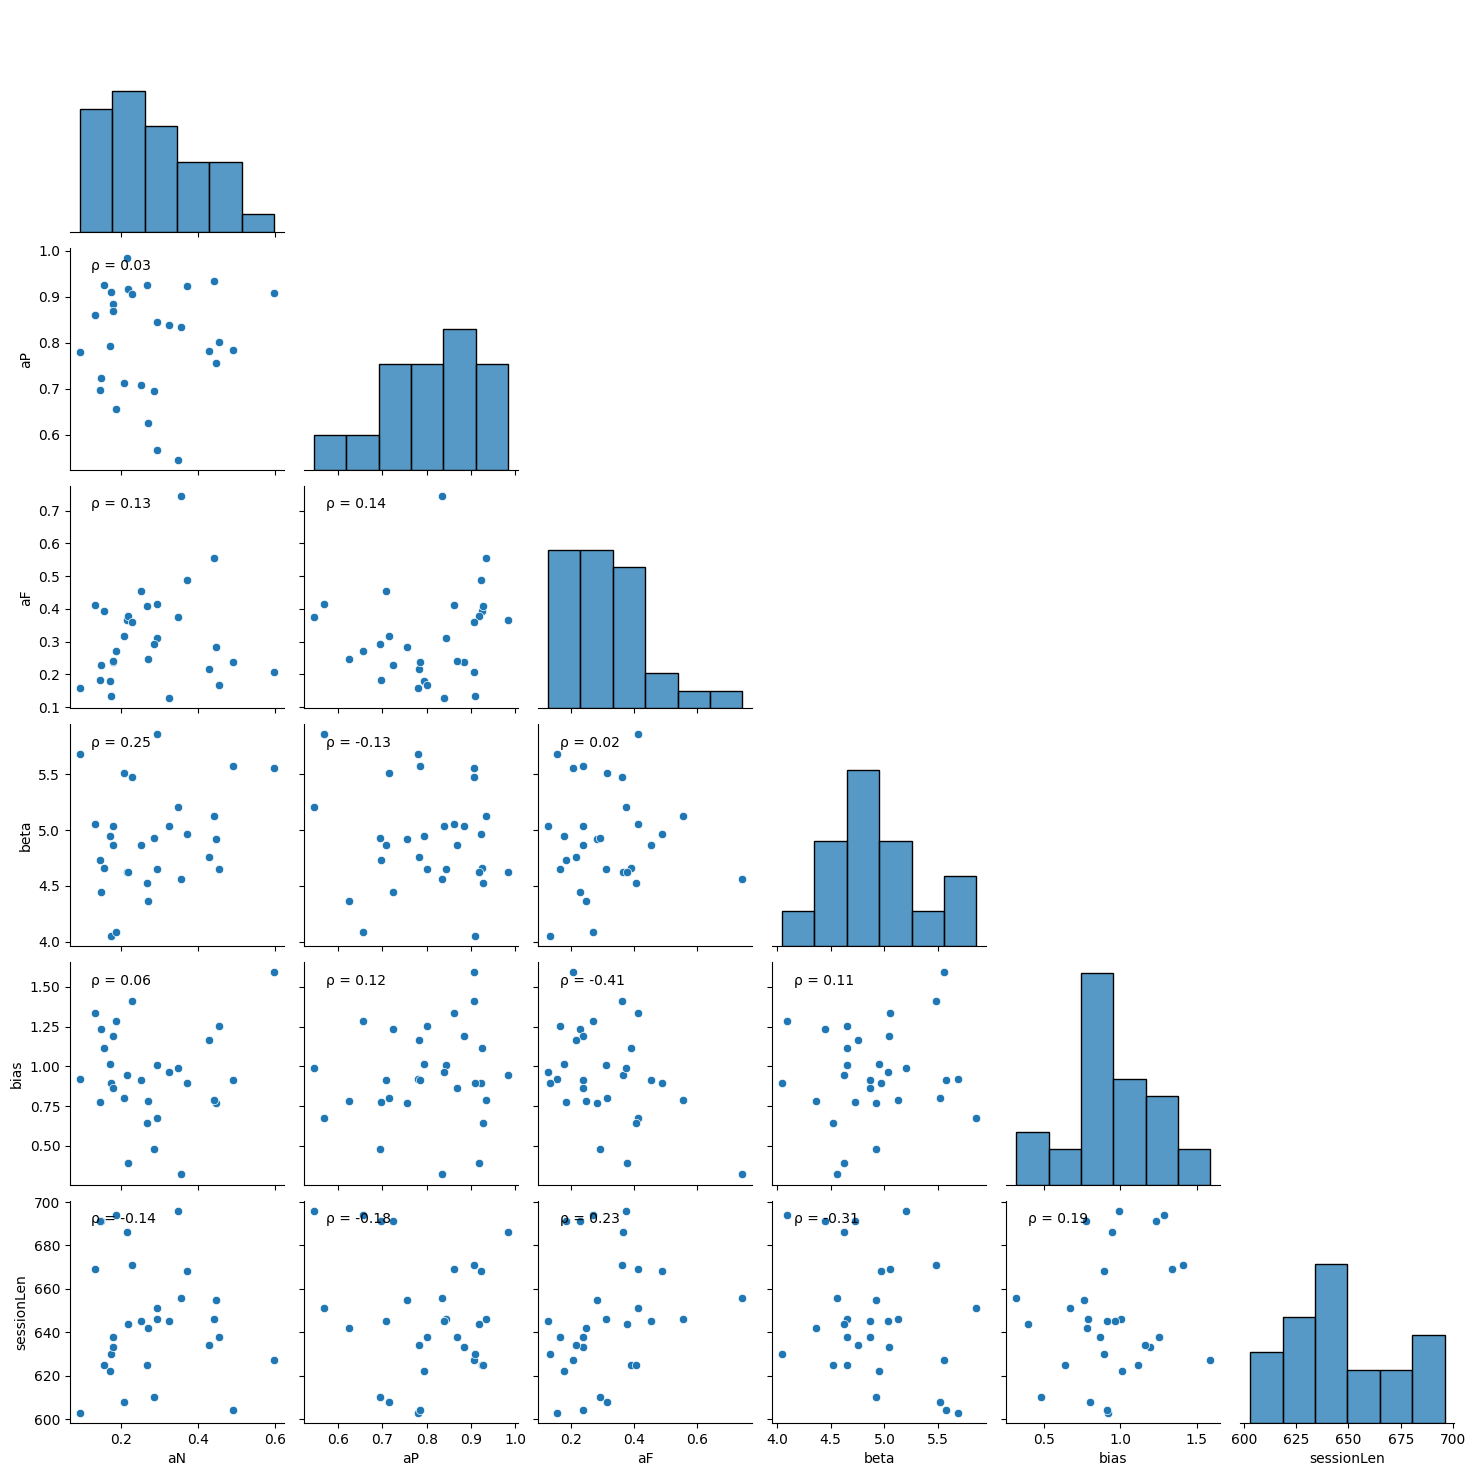

In [3]:
# simulation parameters
np.random.seed(5)
paramsAni = [0.3, 0.8, 0.3, 5, 1]
paramNames = ['aN', 'aP', 'aF', 'beta', 'bias']
sessNum = 30
maxTrial = 700
trialRange = 100
paramsSim = np.zeros((sessNum, len(paramsAni)-1))

total = 10
aN = np.random.beta(total*paramsAni[0], total*(1-paramsAni[0]), size=sessNum)
aP = np.random.beta(total*paramsAni[1], total*(1-paramsAni[1]), size=sessNum)
aF = np.random.beta(total*paramsAni[2], total*(1-paramsAni[2]), size=sessNum)
beta = 3 * (np.random.beta(total * 0.5, total * 0.5, size=sessNum)-0.5) + paramsAni[3]
bias = 2 * (np.random.beta(total * 0.5, total * 0.5, size=sessNum)-0.5) + paramsAni[4]
sessionLen = np.random.random_integers(maxTrial-trialRange, maxTrial, sessNum)

paramsSim = pd.DataFrame({paramNames[0]:aN,
                        paramNames[1]:aP,
                        paramNames[2]:aF,
                        paramNames[3]:beta,
                        paramNames[4]:bias,
                        'sessionLen': sessionLen
                        })
myPairPlot(paramsSim)

/tmp/ipykernel_29377/1806157029.py:14: DeprecationWarning: This function is deprecated. Please call randint(600, 700 + 1) instead
  sessionLen = np.random.random_integers(maxTrial-trialRange, maxTrial, sessNum)


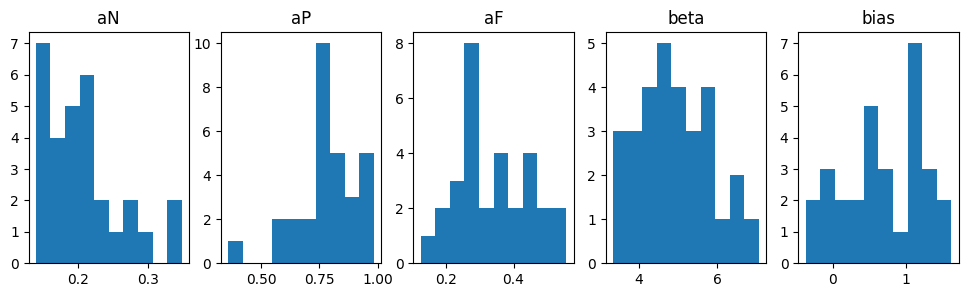

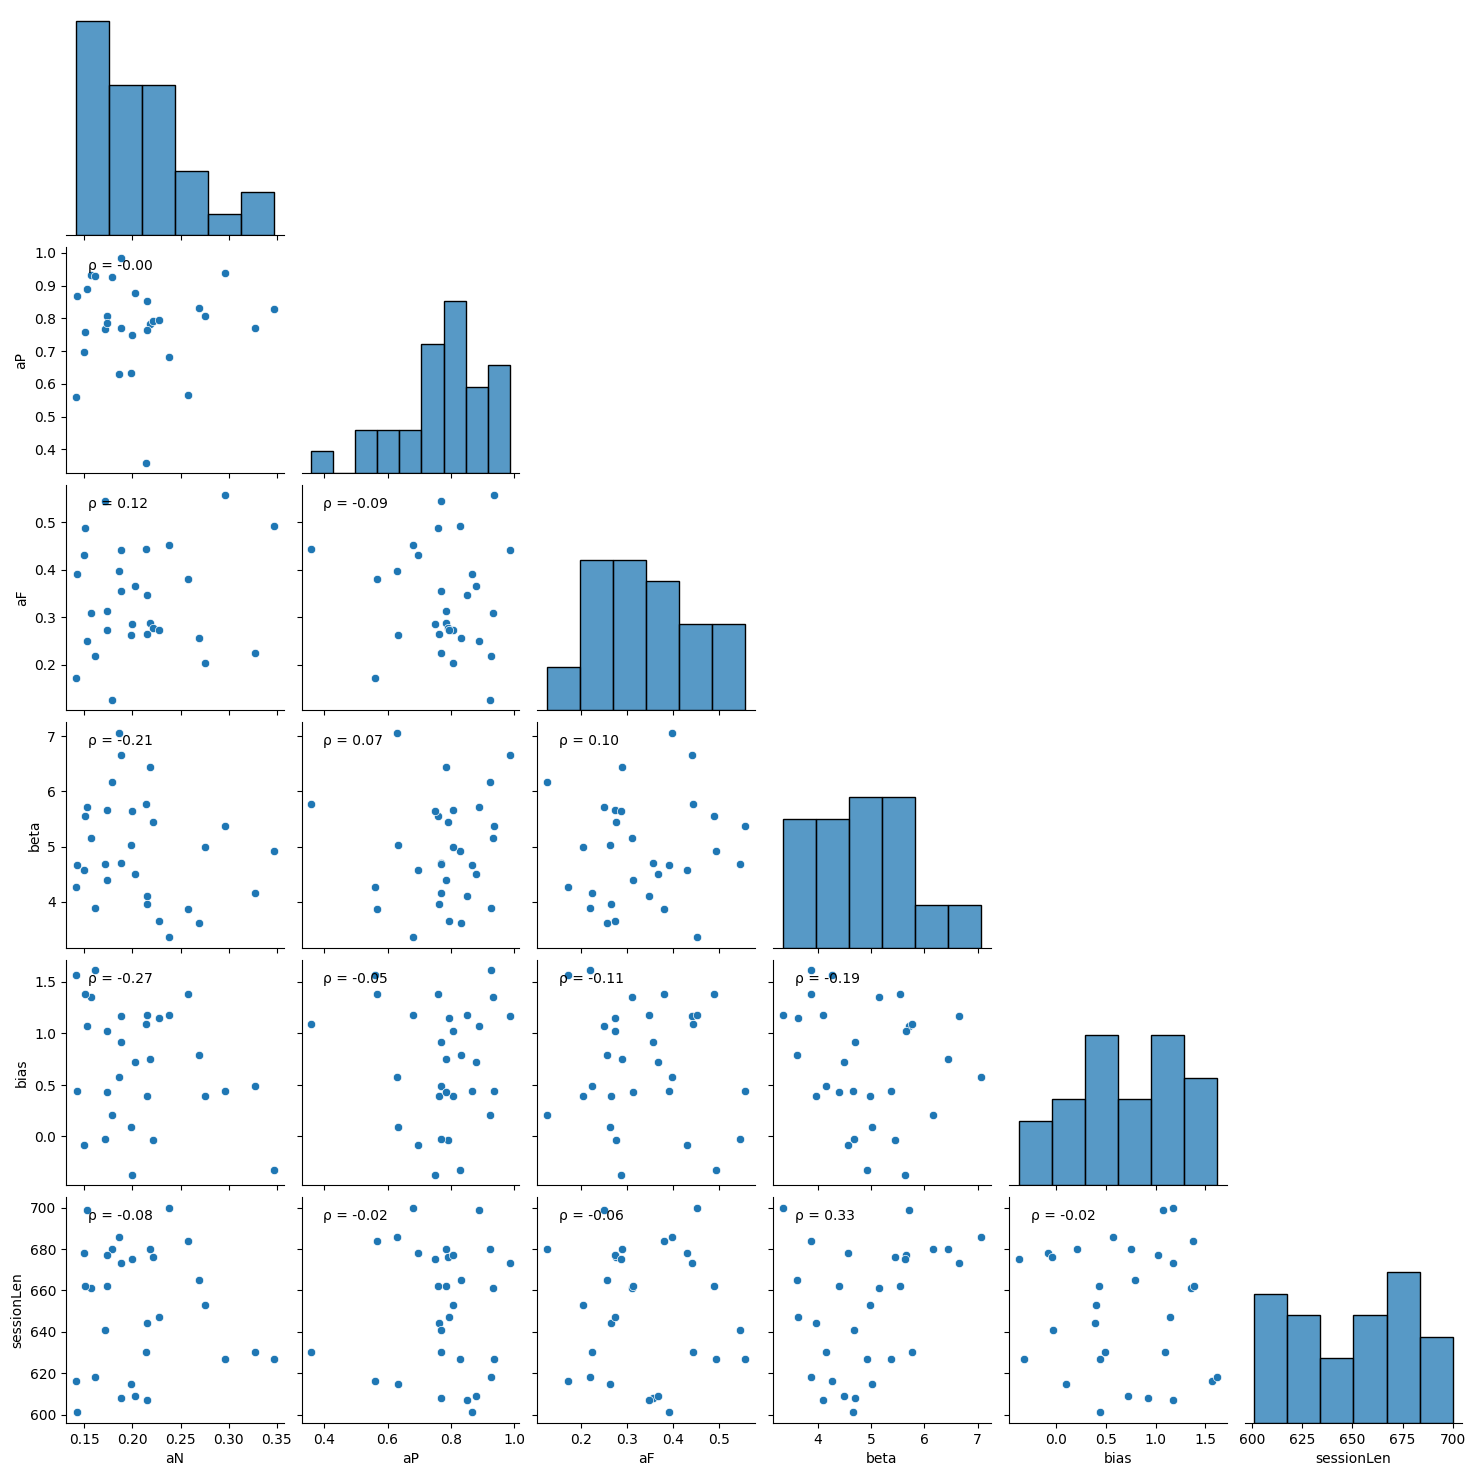

In [4]:
np.random.seed(5)
paramsAni = [0.2, 0.8, 0.3, 5, 0.5]
paramNames = ['aN', 'aP', 'aF', 'beta', 'bias']
paramsRange = [[0, 1],
         [0, 1],
         [0, 1],
         [0, 10]]
sigma = [0.2, 0.5, 0.5, 0.2, 0.5]
fig = plt.figure(figsize=(12, 3))
paramsSim = []
sessNum = 30
maxTrial = 700
trialRange = 100
sessionLen = np.random.random_integers(maxTrial-trialRange, maxTrial, sessNum)
for paramInd, paramName in enumerate(paramNames):
    if 'bias' not in paramName:
        plt.subplot(1, len(paramNames), paramInd+1)
        value = norm.ppf((paramsAni[paramInd] - paramsRange[paramInd][0])/(paramsRange[paramInd][1]-paramsRange[paramInd][0]))
        pSim = norm.rvs(loc = 0, scale = sigma[paramInd], size = sessNum)
        simCurr = (norm.cdf(pSim + value)-paramsRange[paramInd][0])*(paramsRange[paramInd][1]-paramsRange[paramInd][0])
        plt.hist(simCurr, 10)
        plt.title(paramName)
    else:
        simCurr = norm.rvs(loc = paramsAni[paramInd], scale = sigma[paramInd], size = sessNum)
        plt.subplot(1, len(paramNames), paramInd+1)
        plt.hist(simCurr, 10)
        plt.title(paramName)

    paramsSim.append(simCurr)
paramsSim = pd.DataFrame(dict(zip(paramNames, list(paramsSim))))
paramsSim['sessionLen'] = sessionLen
myPairPlot(paramsSim)

In [5]:
# session simulation
choiceSim = []
outcomeSim = []
sessionLen = []


for sessionInd in range(sessNum):
    paramsCurr = paramsSim.loc[sessionInd].values
    paramsCurr = paramsCurr[:-1]
    rlSim = QLearningModelSim(paramsCurr, maxTrial = paramsSim.loc[sessionInd, 'sessionLen'], randomSeed=sessionInd)
    rlSim.run_simulation()
    choiceSim.append(list(rlSim.allChoices))
    outcomeSim.append(list(rlSim.allRewards)) 
    sessionLen.append(len(rlSim.allChoices))

In [6]:
# make data for stan
maxLen = max(sessionLen)
allChoiceArray = choiceSim
allOutcomeArray = outcomeSim
allChoiceArray = np.array([np.pad(choiceSimCurr, (0, maxLen-sessionLenCurr), mode='constant') for choiceSimCurr, sessionLenCurr in zip(choiceSim, sessionLen)]).astype(int)
allOutcomeArray = np.array([np.pad(outcomeSimCurr, (0, maxLen-sessionLenCurr), mode='constant') for outcomeSimCurr, sessionLenCurr in zip(outcomeSim, sessionLen)]).astype(int)
sim_data = {"N": sessNum,
            "T": maxLen,
            "Tsesh": sessionLen,
            "choice": allChoiceArray,
            "outcome": allOutcomeArray}

In [7]:
# Read the Stan model from a file
model = '/code/stan_qLearning_5params.stan'
with open(model, "r") as file:
    model_code = file.read()

In [8]:
# fitting
posterior = stan.build(model_code, data=sim_data)
fit = posterior.sample(num_chains=16, num_samples=2000, num_warmup=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_xyh1bke2/model_pq6x74ud.stan', line 73, column 8: A
    control flow statement depends on parameter(s): aF_pr, aN_pr, aP_pr,
    mu_p, sigma.
Warning in '/tmp/httpstan_xyh1bke2/model_pq6x74ud.stan', line 65, column 8: A
    control flow statement depends on parameter(s): aF_pr, aN_pr, aP_pr,
    mu_p, sigma.
Warning in '/tmp/httpstan_xyh1bke2/model_pq6x74ud.stan', line 49, column 19: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/48000)
Sampling:   0% (2/48000)
Sampling:   0% (3/48000)
Sampling:   0% (4/48000)
Sampling:   0% (5/48000)
Sampling:   0% (6/48000)
Sampling:   0% (7/48000)
Sampling:   0% (8/48000)
Sampling:   0% (9/48000)
Sampling:   0% (10/48000)
Sampling:   0% (11/48000)
Sampling:   0% (12/48000)
Sampling:   0% (13/48000)
Sampling:   0% (14/48000)
Sampling:   0% (15/48

In [9]:
# summarize
summaryMean = az.summary(fit, stat_focus = 'mean')
summaryMedian = az.summary(fit, stat_focus = 'median')
summary = pd.merge(summaryMean, summaryMedian, left_index=True, right_index=True)

In [ ]:
# save
# make session-wise dataframe
# save 
name = 'modelSimStanTest2'
saveDir = path.expanduser('~/capsule/scratch/'+name)
os.makedirs(saveDir, exist_ok=True)

paramsFit = getSessionFitParams(summary, paramNames, focus = 'mean')

summary.to_csv(saveDir+'/summary.csv', index=True)
paramsSim.to_csv(saveDir+'/paramsSim.csv')  
paramsFit.to_csv(saveDir+'/paramsFit.csv')

samples = dict(fit)
with open(saveDir+'/samples', 'wb') as pickle_file:
    pickle.dump(samples, pickle_file)


basicInfo = dict({'paramsAni':paramsAni, 'paramNames': paramNames, 'paramsRange':paramsRange, 'sessNum':sessNum, 'maxTrial': maxTrial, 'trialRange': trialRange})

with open(saveDir+'/basicInfo', 'w') as json_file:
    json.dump(basicInfo, json_file)

with open(saveDir+'/choiceSim', 'w') as json_file:
    json.dump(choiceSim, json_file)

with open(saveDir+'/outcomeSim', 'w') as json_file:
    json.dump(outcomeSim, json_file)